In [1]:
from transformers import BertModel, BertTokenizer
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = BertTokenizer.from_pretrained("./bert")
model = BertModel.from_pretrained("./bert").to(device)
def bert_embedding(text):
    encoded_input = tokenizer(text, return_tensors='pt').to(device)
    output = model(**encoded_input)
    return output.last_hidden_state.cpu().detach()

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas
import torch

train_pd = pandas.read_csv("./data/train.csv")
test_pd = pandas.read_csv("./data/test.csv")
train_X_pos, train_X_neg = [], []
test_X = []
vectorizer = TfidfVectorizer()

all_text = pandas.concat([train_pd['text'], test_pd['text']], axis=0)
vectorizer.fit(all_text)
train_X = vectorizer.transform(train_pd['text'])
test_X = vectorizer.transform(test_pd['text'])
train_X_pos = train_X[train_pd['target'] == 1]
train_X_neg = train_X[train_pd['target'] == 0]


Define model class.

In [21]:
import torch
n_features = len(vectorizer.get_feature_names_out())
print(n_features)
class Decoder(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.bilstm = nn.LSTM(input_size=n_features, hidden_size=16, num_layers=1, bidirectional=True, batch_first=True)

        self.attention = torch.nn.MultiheadAttention(32, 1, batch_first=True)
        self.fc = torch.nn.Linear(32, 2)

    def forward(self, x):
        x, _ = self.bilstm(x)
        x, _ = self.attention(x, x, x)
        x = x[:, 0, :]
        x = self.fc(x)
        return x

27922


In [5]:
import random


def align(X, max_length=32):
    if X.shape[0] < max_length:
        X = torch.concat([X, torch.zeros((max_length - X.shape[0], X.shape[1]))], dim=0)
    return X[:max_length, :]

random.seed(1)
train_X_pos_tensors = [torch.tensor(X.toarray()) for X in train_X_pos]
train_X_neg_tensors = [torch.tensor(X.toarray()) for X in train_X_neg]
select = [(align(X), 1) for X in train_X_pos_tensors] + [(align(X), 0) for X in train_X_neg_tensors]
random.shuffle(select)
train_set = select[:]
val_set = select[int(0.9 * len(select)):]
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

In [18]:
import torch.nn as nn

device = "cuda" if torch.cuda.is_available() else "cpu"
decoder = Decoder().to(device)
epochs = 50
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss().to(device)
train_acc=[]
val_acc = []
for epoch in range(epochs):
    decoder.train()
    for data, label in train_loader:
        data, label = data.float().to(device), label.to(device)
        output = decoder(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    decoder.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in train_loader:
            data, label = data.float().to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)

    train_acc.append(correct / total)
    print(f"epoch: {epoch}, train acc: {correct / total}")
    correct, total = 0, 0
    with torch.no_grad():
        for data, label in val_loader:
            data, label = data.float().to(device), label.to(device)
            output = torch.argmax(decoder(data), dim=1)
            correct += torch.sum(output == label)
            total += data.size(0)
    val_acc.append(correct / total)
    print(f"epoch: {epoch}, val acc: {correct / total}")

epoch: 0, train acc: 20.000000046064223
epoch: 0, val acc: 20.01766094324104
epoch: 1, train acc: 20.0069376465
epoch: 1, val acc: 20.03784936628422
epoch: 2, train acc: 20.00766772340861
epoch: 2, val acc: 20.11607806863097
epoch: 3, train acc: 20.020050984520516
epoch: 3, val acc: 20.12337049570623
epoch: 4, train acc: 20.045199799252963
epoch: 4, val acc: 20.158877930272887
epoch: 5, train acc: 20.180841897382443
epoch: 5, val acc: 20.474617175963065
epoch: 6, train acc: 20.770997611632268
epoch: 6, val acc: 20.860446106043106
epoch: 7, train acc: 20.965907651095094
epoch: 7, val acc: 21.026087291945863
epoch: 8, train acc: 21.466239775077796
epoch: 8, val acc: 21.061683458241294
epoch: 9, train acc: 21.497473983369304
epoch: 9, val acc: 22.555409376876838
epoch: 10, train acc: 21.670848391014072
epoch: 10, val acc: 22.827065382305502
epoch: 11, train acc: 22.17573214929281
epoch: 11, val acc: 22.868424433854916
epoch: 12, train acc: 22.48615402744424
epoch: 12, val acc: 22.96636966

Print the metrics of the trained models on training set and validation set.

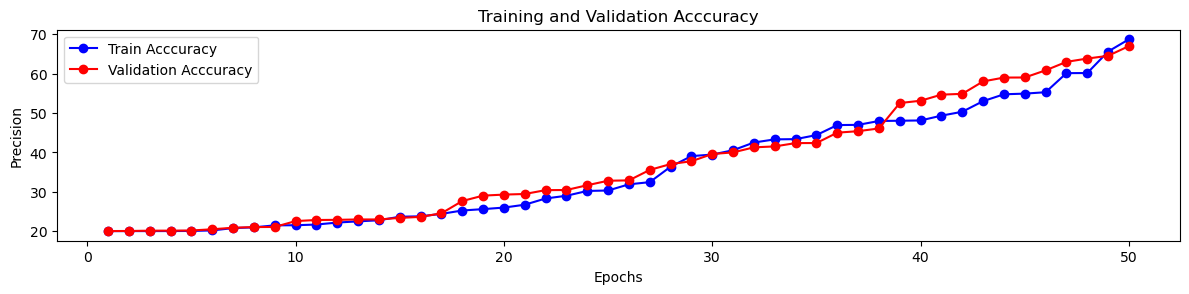

In [20]:
import matplotlib.pyplot as plt
epochs2 = range(1, 50 + 1)
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(epochs2, train_acc, 'bo-', label='Train Acccuracy')
plt.plot(epochs2, val_acc, 'ro-', label='Validation Acccuracy')
plt.title('Training and Validation Acccuracy')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()


plt.tight_layout()
plt.show()
